In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#for converting MTM geo location to normal lat and long
from pyproj import Proj, transform

import gmplot
import gmaps

# For improved table display in the notebook
from IPython.display import display

## Read in Watermain Failue Data

In [29]:
df = pd.read_csv('WatermainBreaks.csv')

In [3]:
df.head()

,BREAK DATE,BREAK YEAR,X COORD,Y COORD
0,1/1/1990,1990,301316.434,4829245.578
1,1/1/1990,1990,326711.060,4846900.024
2,1/1/1990,1990,307098.866,4841152.120
3,1/1/1990,1990,306976.247,4842116.883
4,1/1/1990,1990,326543.178,4847968.844


## Explore Time Features

In [30]:
#convert to datetime object
df['BREAK DATE'] = pd.to_datetime(df['BREAK DATE'])

In [31]:
#Add datetime features
mapper = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}


df['Month'] = df['BREAK DATE'].apply(lambda x: x.month)
df['Day'] = df['BREAK DATE'].apply(lambda x: x.day)
df['Day of Week'] =  df['BREAK DATE'].apply(lambda x: x.dayofweek).map(mapper)

In [26]:
df.head()

,BREAK DATE,BREAK YEAR,X COORD,Y COORD,Month,Day,Day of Week
0,1990-01-01,1990,301316.434,4829245.578,1,1,Monday
1,1990-01-01,1990,326711.060,4846900.024,1,1,Monday
2,1990-01-01,1990,307098.866,4841152.120,1,1,Monday
3,1990-01-01,1990,306976.247,4842116.883,1,1,Monday
4,1990-01-01,1990,326543.178,4847968.844,1,1,Monday


Text(0.5,1,'Water Main Break by Month (1990-2016)')

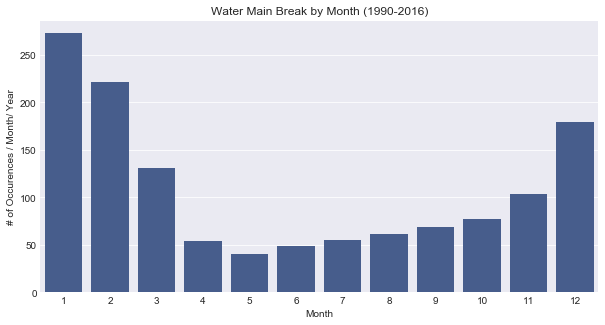

In [128]:
#Breaks by Month
byMonth = df.groupby(by='Month',axis=0).count()/df['BREAK YEAR'].nunique()

plt.figure(figsize=(10,5))
sns.barplot(x = byMonth.index,  y='BREAK YEAR', data=byMonth, color = '#3B5998')
plt.ylabel('# of Occurences / Month/ Year')
plt.title('Water Main Break by Month (1990-2016)')

- Suggests seasonality or weather correlation

Text(0.5,1,'Water Main Break by Weekday (1990-2016)')

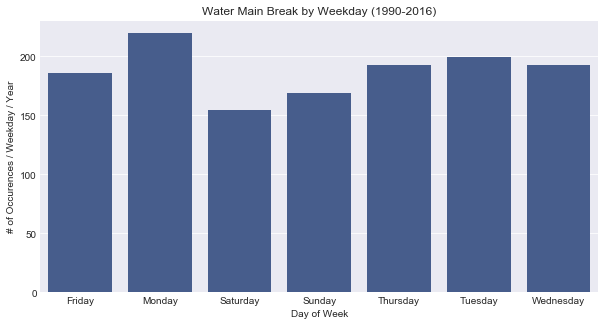

In [130]:
byDayofweek = df.groupby(by='Day of Week',axis=0).count()/df['BREAK YEAR'].nunique()

plt.figure(figsize=(10,5))
sns.barplot(x = byDayofweek.index,  y='BREAK YEAR', data=byDayofweek, color = '#3B5998')
plt.ylabel('# of Occurences / Weekday / Year')
plt.title('Water Main Break by Weekday (1990-2016)')

- Suggest begining of week hotspots for breaks, I hate mondays

In [32]:
#Explore last year
df_2016 = df[df['BREAK YEAR'] == 2016]

Text(0.5,1,'Water Main Break by Month (2016)')

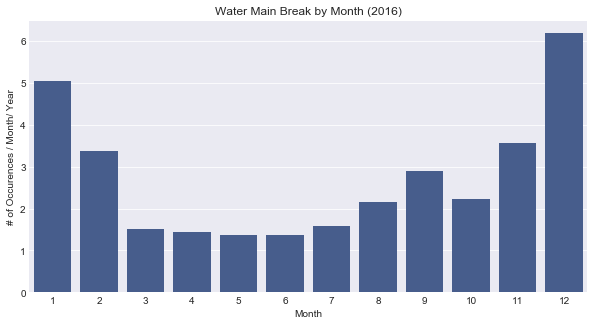

In [126]:
#Breaks by Month
byMonth = df_2016.groupby(by='Month',axis=0).count()/df['BREAK YEAR'].nunique()

plt.figure(figsize=(10,5))
sns.barplot(x = byMonth.index,  y='BREAK YEAR', data=byMonth, color = '#3B5998')
plt.ylabel('# of Occurences / Month/ Year')
plt.title('Water Main Break by Month (2016)')

Text(0.5,1,'Water Main Break by Weekday (2016)')

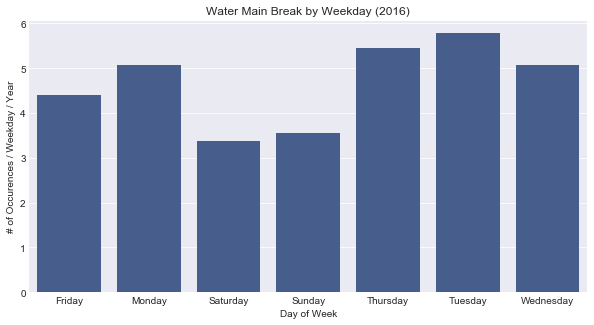

In [127]:
byDayofweek = df_2016.groupby(by='Day of Week',axis=0).count()/df['BREAK YEAR'].nunique()

plt.figure(figsize=(10,5))

sns.barplot(x = byDayofweek.index,  y='BREAK YEAR', data=byDayofweek, color = '#3B5998')
plt.ylabel('# of Occurences / Weekday / Year')
plt.title('Water Main Break by Weekday (2016)')

## Explore Geographical Features (Only 2016)

In [5]:
#MTM to Lat/Long
#http://www.noqcks.io/notes/2017/04/29/toronto-geocoding-mtm-to-wsg84/

def MTMtoWGS84(df):
    
    
    inProj = Proj(init='epsg:2019')
    outProj = Proj(init='epsg:4326')

    x1 = df['X COORD']
    y1 = df['Y COORD']
    
    x2,y2 = transform(inProj,outProj,x1,y1)
    
    df['Lat'] = y2
    df['Long'] = x2
    
    return df

In [6]:
df_2016 = df_2016.apply(MTMtoWGS84, axis=1)
df_2016.head()

,BREAK DATE,BREAK YEAR,X COORD,Y COORD,Lat,Long
34582,1/2/2016,2016,312165.112,4848233.259,43.775967,-79.408510
34583,1/3/2016,2016,297675.325,4838998.379,43.692844,-79.588381
34584,1/3/2016,2016,296964.031,4844108.396,43.738833,-79.597279
34585,1/3/2016,2016,322201.163,4850645.062,43.797509,-79.283763
34586,1/4/2016,2016,300400.406,4834610.102,43.653364,-79.554541


In [8]:
lat = df_2016['Lat']
long = df_2016['Long']

locations = list(zip(lat.values,long.values))

In [11]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
fig

Figure(layout=FigureLayout(height='420px'))

## Explore External Datasets and Correlations

Hypothesis

- Weather Data
- Consumption
- Demographic features (income per area, population etc.)

### Explore Weather

In [19]:
#Weather
df_weather = pd.read_csv('StatsCan Weather Data Station 31688 2016-2016')

In [20]:
df_weather['Date/Time'] = pd.to_datetime(df_weather['Date/Time'])

df_weather.set_index('Date/Time', inplace = True)

In [21]:
df_weather_daily = df_weather.resample('D').mean()

In [23]:
df_weather_daily_cleaned = df_weather_daily[['Temp (°C)','Rel Hum (%)','Stn Press (kPa)','Dew Point Temp (°C)']]

In [25]:
df_weather_daily_cleaned.reset_index(inplace=True)

In [26]:
df_weather_daily_cleaned.head()

,Date/Time,Temp (°C),Rel Hum (%),Stn Press (kPa),Dew Point Temp (°C)
0,2016-01-01,-0.916667,73.250000,100.197917,-5.137500
1,2016-01-02,-0.675000,72.583333,99.937500,-4.991667
2,2016-01-03,-1.175000,70.166667,99.680417,-5.920833
3,2016-01-04,-11.933333,57.416667,101.498333,-18.733333
4,2016-01-05,-7.391304,64.217391,102.147826,-13.082609


In [43]:
df_2016_mergeprep = df_2016.rename(mapper={'BREAK DATE':'Date/Time'},axis=1)
df_2016_mergeprep = df_2016_mergeprep.groupby('Date/Time').count()['BREAK YEAR'].reset_index()

In [59]:
merge = df_weather_daily_cleaned.merge(df_2016_mergeprep,on='Date/Time',how='left')
merge = merge.rename(mapper={'BREAK YEAR':'Number of Failures'},axis=1)

In [60]:
merge.fillna(value=0,inplace=True)

In [ ]:
weatherbreakcorr = merge.corr()
print(weatherbreakcorr)

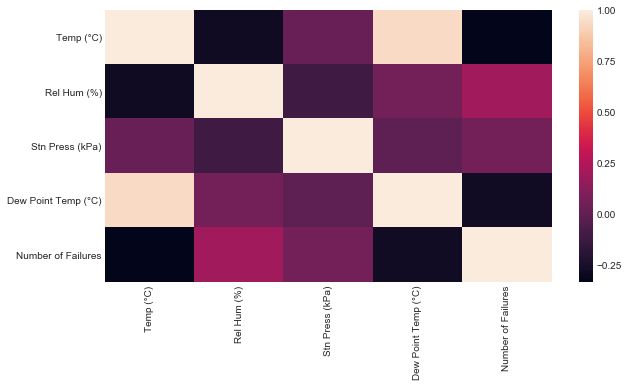

In [124]:
plt.figure(figsize=(10,5))
sns.heatmap(weatherbreakcorr)

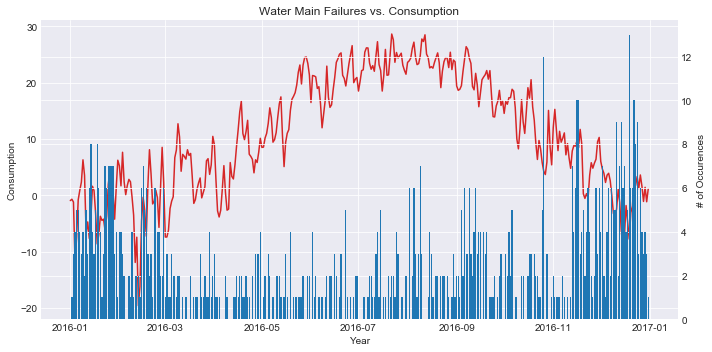

In [122]:
# Create some mock data
data1 = merge['Temp (°C)'].values
data2 = merge['Number of Failures'].values
t = merge['Date/Time'].values

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 5, forward=True)

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Consumption')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# of Occurences')  # we already handled the x-label with ax1
ax2.bar(t, data2, color=color)
ax2.tick_params(axis='y')

plt.title('Water Main Failures vs. Consumption')
fig.tight_layout() 



- Temperature neg corr with pip failure (i.e more breaks in winter time)
- Slight positive correlations with relative humidity and bar pressure

### Explore Consumption

In [77]:
data = np.array([[2010,318381748.58],
                 [2011,320080300.48],
                 [2012, 306497042.00],
                 [2013, 327579236.76],
                 [2014, 319702744.29 ],
                 [2015,307105017.78],
                ])

consump = pd.DataFrame(data,columns=['Date','Total Consumption'])
consump['Date'] = consump['Date'].astype(int)

In [78]:
consump

,Date,Total Consumption
0,2010,3.183817e+08
1,2011,3.200803e+08
2,2012,3.064970e+08
3,2013,3.275792e+08
4,2014,3.197027e+08
5,2015,3.071050e+08


In [89]:
consump['# of Failures'] = df.groupby('BREAK YEAR').count()['BREAK DATE'][20:-1].values

In [90]:
consump

,Date,Total Consumption,# of Failures
0,2010,3.183817e+08,940
1,2011,3.200803e+08,1080
2,2012,3.064970e+08,769
3,2013,3.275792e+08,1193
4,2014,3.197027e+08,1271
5,2015,3.071050e+08,1353


In [91]:
consump[['Total Consumption','# of Failures']].corr()

,Total Consumption,# of Failures
Total Consumption,1.000000,0.238883
# of Failures,0.238883,1.000000


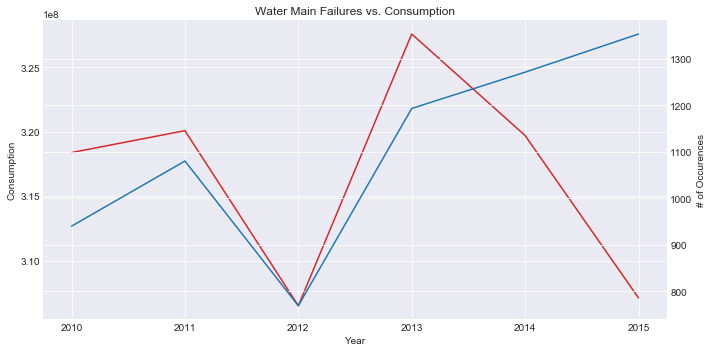

In [123]:
# Create some mock data
data1 = consump['Total Consumption'].values
data2 = consump['# of Failures'].values
t = consump['Date'].values

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 5, forward=True)


color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Consumption')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# of Occurences')  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y')

plt.title('Water Main Failures vs. Consumption')
fig.tight_layout() 

- Slight correlation between consumption and failures